In [1]:
import torch 
import torch.nn as nn
import gym
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt 
device = torch.device('cuda:0')

In [2]:
env = gym.make('CartPole-v1')
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

In [3]:
class Policy(nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        
        self.policy = nn.Sequential( nn.Linear( state_space, 128, bias=False),
                                     nn.ReLU(), 
                                     nn.Linear(128, action_space, bias=False),
                                     nn.Softmax(dim=-1) )


    def forward(self, state):    
        # get action prob 
        action_prob = self.policy(state)    
        return action_prob 


In [4]:
class REINFORCE():
    def __init__(self,env, policy, opt):
        
        self.env = env
        self.policy = policy 
        self.opt = opt
        
        self.episode_total_reward_log = [] 
        
    def interact(self):
        "Agent first interacts with env to collect data"
        
        # prepare data list
        self.episode_reward_list = []
        self.episode_action_list = []
        self.episode_state_list = []
        
        # init env 
        state = self.env.reset()
        done = False 
        total_reward = 0
        
        # start this episode until done
        while not done:  
            
            with torch.no_grad():
                
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
                
                # forward to get prob 
                action_prob = self.policy( state )
                # according to prob we create a Categorical Distribution 
                distribution = Categorical(action_prob)
                # we sample from this distribution to get action 
                action = distribution.sample()    
                # step env 
                next_state, reward, done, _ = env.step( int(action.cpu()) )
                total_reward += reward 
                # append data 
                self.episode_reward_list.append( reward )
                self.episode_action_list.append( action )
                self.episode_state_list.append( state )
                
                state = next_state
                
        # used for display
        self.episode_total_reward_log.append(total_reward)
                
                
    def discount_reward(self, gamma):
        "This implementation has baseline"    
        
        ep_len = len(self.episode_reward_list)        
        r = np.array( [   gamma**i * self.episode_reward_list[i] for i in range(ep_len)  ] )
        
        # Reverse direction for cumsum and then reverse it back, which is discounted cumulative reward         
        r = r[::-1].cumsum()[::-1]
        return r - r.mean()
    
    
    def update(self, discounted_reward):
        
        self.opt.zero_grad()
       
        # assemble state after one epoch 
        batch_state = torch.cat( self.episode_state_list, dim=0 )
        batch_action = torch.cat( self.episode_action_list, dim=0 )
        
        # calculate log prob
        batch_action_prob = self.policy( batch_state )
        batch_distribution = Categorical(batch_action_prob)
        batch_log_prob = batch_distribution.log_prob(batch_action)
        
        # calculate loss and update 
        loss = - ( batch_log_prob * torch.FloatTensor(discounted_reward).to(device) ).mean()
        loss.backward()
        
        self.opt.step()        
        
                
    def train(self, episodes, gamma=0.99):
        
        for i in range(episodes):
            
            # first, let agent play with env 
            self.interact()

            # we calculate discounted reward 
            discounted_reward = self.discount_reward(gamma)

            # update after one episopde 
            self.update(discounted_reward)
            
            print( 'total reward of '+str(i)+ ' episode is ' +str(self.episode_total_reward_log[-1]) )
            
            
    
    def plot(self, avg_window=10):
        
        rewards = self.episode_total_reward_log
        smoothed_rewards = [np.mean(rewards[i-avg_window:i+1]) if i > avg_window else np.mean(rewards[:i+1]) for i in range(len(rewards))]

        plt.figure(figsize=(12,8))
        plt.plot(rewards)
        plt.plot(smoothed_rewards)
        plt.ylabel('Total Rewards')
        plt.xlabel('Episodes')
        plt.show()           
        

In [5]:
policy = Policy(state_space,action_space).to(device)
opt = torch.optim.RMSprop( policy.parameters(), lr=0.002)

In [6]:
reinforce = REINFORCE(env=env, policy=policy, opt=opt)

In [7]:
reinforce.train(500)

total reward of 0 episode is 12.0
total reward of 1 episode is 20.0
total reward of 2 episode is 13.0
total reward of 3 episode is 16.0
total reward of 4 episode is 16.0
total reward of 5 episode is 11.0
total reward of 6 episode is 29.0
total reward of 7 episode is 27.0
total reward of 8 episode is 16.0
total reward of 9 episode is 98.0
total reward of 10 episode is 20.0
total reward of 11 episode is 47.0
total reward of 12 episode is 20.0
total reward of 13 episode is 21.0
total reward of 14 episode is 55.0
total reward of 15 episode is 23.0
total reward of 16 episode is 11.0
total reward of 17 episode is 85.0
total reward of 18 episode is 23.0
total reward of 19 episode is 58.0
total reward of 20 episode is 88.0
total reward of 21 episode is 25.0
total reward of 22 episode is 17.0
total reward of 23 episode is 78.0
total reward of 24 episode is 20.0
total reward of 25 episode is 25.0
total reward of 26 episode is 57.0
total reward of 27 episode is 57.0
total reward of 28 episode is 

total reward of 228 episode is 470.0
total reward of 229 episode is 117.0
total reward of 230 episode is 500.0
total reward of 231 episode is 357.0
total reward of 232 episode is 419.0
total reward of 233 episode is 500.0
total reward of 234 episode is 275.0
total reward of 235 episode is 233.0
total reward of 236 episode is 254.0
total reward of 237 episode is 211.0
total reward of 238 episode is 500.0
total reward of 239 episode is 500.0
total reward of 240 episode is 408.0
total reward of 241 episode is 500.0
total reward of 242 episode is 397.0
total reward of 243 episode is 222.0
total reward of 244 episode is 429.0
total reward of 245 episode is 320.0
total reward of 246 episode is 329.0
total reward of 247 episode is 270.0
total reward of 248 episode is 232.0
total reward of 249 episode is 244.0
total reward of 250 episode is 458.0
total reward of 251 episode is 222.0
total reward of 252 episode is 411.0
total reward of 253 episode is 500.0
total reward of 254 episode is 500.0
t

total reward of 452 episode is 500.0
total reward of 453 episode is 500.0
total reward of 454 episode is 500.0
total reward of 455 episode is 500.0
total reward of 456 episode is 409.0
total reward of 457 episode is 500.0
total reward of 458 episode is 452.0
total reward of 459 episode is 500.0
total reward of 460 episode is 500.0
total reward of 461 episode is 500.0
total reward of 462 episode is 500.0
total reward of 463 episode is 500.0
total reward of 464 episode is 500.0
total reward of 465 episode is 489.0
total reward of 466 episode is 500.0
total reward of 467 episode is 371.0
total reward of 468 episode is 500.0
total reward of 469 episode is 355.0
total reward of 470 episode is 274.0
total reward of 471 episode is 500.0
total reward of 472 episode is 500.0
total reward of 473 episode is 369.0
total reward of 474 episode is 180.0
total reward of 475 episode is 313.0
total reward of 476 episode is 500.0
total reward of 477 episode is 490.0
total reward of 478 episode is 500.0
t

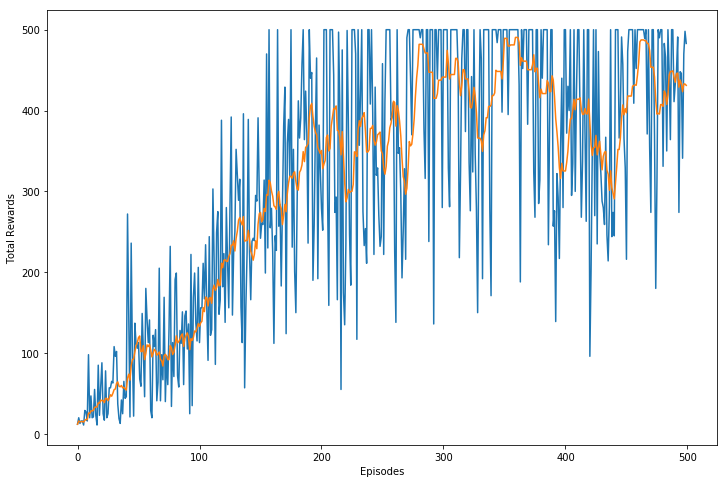

In [8]:
reinforce.plot()

In [9]:
# This is the learned policy 
state = env.reset()
done = False 
total_reward = 0
while not done:  

    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_prob = policy( state )
        distribution = Categorical(action_prob)  
        action = distribution.sample() 
        env.render()
        state, reward, done, _ = env.step( int(action.cpu()) )
        total_reward += reward
print('total reward is ' + str(total_reward))

total reward is 417.0


In [10]:
# This is a random policy 
state = env.reset()
done = False 
total_reward = 0
while not done:
    with torch.no_grad():
        env.render()
        state, reward, done, _ = env.step( env.action_space.sample() )
        total_reward += reward
print('total reward is ' + str(total_reward))

total reward is 13.0
